## **1.Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Cargar el archivo Excel
df = pd.read_excel("DatosAgroNet_limpio.xlsx")

# Mostrar las primeras filas
print(df.head())

       Fecha  COP/kg
0 2020-01-06  7023.8
1 2020-01-13  7312.7
2 2020-01-20  7434.0
3 2020-01-27  7875.7
4 2020-02-03  7954.5


## **2. Función para hacer el backtesting**
En este caso, para validar este modelo realizaremos un *backtesting* mediante el método de *rolling window* o *walk-forward*. Este método funciona tomando un bloque inicial (ej. 2020–2022), se entrena y se predice para 2023. Luego se avanza una ventana (2021–2023), se entrena y predice para 2024 y así repitiendo varias veces. Finalmente nos da un error promedio (MAE) que nos sirve para saber si el modelo es estable y confiable.

La función hace uso de los siguientes parámetros:

**data:** serie de tiempo del precio histórico  
**order:** parámetros ARIMA (p,d,q)  
**seasonal_order:** parámetros estacionales (P,D,Q,s)  
**train_size:** proporción inicial de entrenamiento, por ejemplo 70/30 o 80/20  
**steps:** horizonte de predicción (semanas)  


In [3]:
def rolling_backtest(data, order, seasonal_order, train_size=0.8, steps=26):

    n = len(data) # se calcula el número total de observaciones en la serie
    split = int(train_size * n) # se calcula el índice donde termina el set de entrenamiento inicial
    
    mae_list = []
    rmse_list = []
    mape_list = []

    for i in range(split, n - steps): # se recorre desde el indice inicial hasta que falten observaciones
        train = data.iloc[:i] # para entrenar todos los datos hasta el índice i
        test = data.iloc[i:i+steps] # para test los siguientes después del índice i

        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            forecast = results.forecast(steps=len(test))
            
            # Cálculo de métricas
            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = np.mean(np.abs((test - forecast) / test)) * 100

            mae_list.append(mae)
            rmse_list.append(rmse)
            mape_list.append(mape)

        except:
            continue

    return {
        "mae": np.mean(mae_list),
        "rmse": np.mean(rmse_list),
        "mape": np.mean(mape_list)}

## **3. Definir los parámetros**
`(p,d,q)` → parte no estacional

p: rezagos autorregresivos (cuántos valores pasados usa).  
d: diferencias necesarias para estacionarizar la serie.  
q: rezagos de errores pasados (parte MA).

`(P,D,Q,s)` → parte estacional

P: rezagos autorregresivos estacionales.  
D: diferencias estacionales necesarias (ej. 1 si la serie tiene ciclos anuales).  
Q: rezagos de errores pasados estacionales.  
s: longitud del ciclo → en datos semanales es 52 (1 año ≈ 52 semanas).

In [4]:
order = (1,2,2)
seasonal_order = (1,1,1,26) #estacionalidad por 6 meses

# Backtesting
metricas = rolling_backtest(df['COP/kg'], order, seasonal_order)
print(f"MAE promedio en backtesting: {metricas['mae']:.2f}")
print(f"RMSE promedio en backtesting: {metricas['rmse']:.2f}")
print(f"MAPE promedio en backtesting: {metricas['mape']:.2f}%")

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

MAE promedio en backtesting: 8901.70
RMSE promedio en backtesting: 10758.93
MAPE promedio en backtesting: 31.94%


## **4. Aplicar el modelo a los datos**

In [5]:
#order = (1,2,2)
#seasonal_order = (1,1,1,52)

model = SARIMAX(df['COP/kg'], order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

print("AIC del modelo:",results.aic)

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC del modelo: 3872.921329467905


In [6]:
forecast = results.get_forecast(steps=26)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

## **5. Graficar los resultados del forecast**

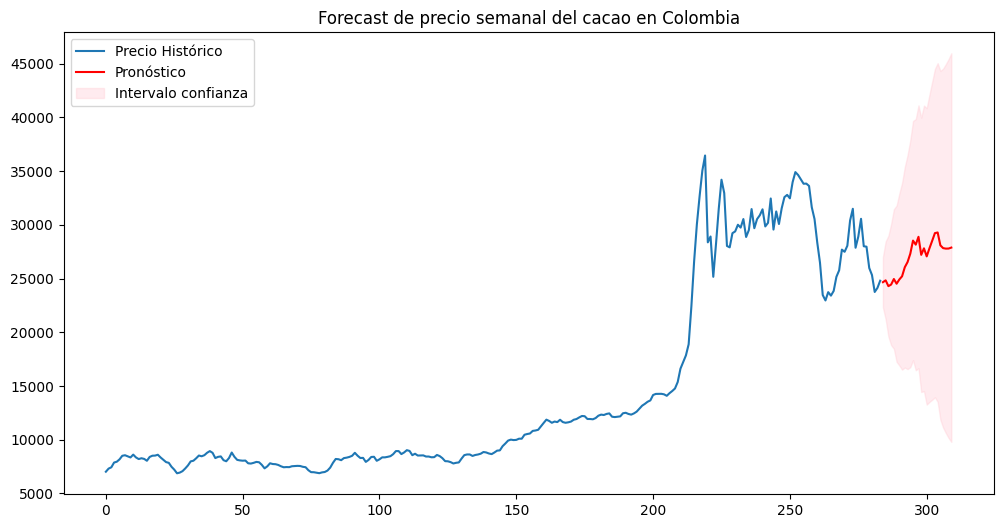

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['COP/kg'], label="Precio Histórico")
plt.plot(pred_mean.index, pred_mean, label="Pronóstico", color='red')
plt.fill_between(pred_mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                 color='pink', alpha=0.3, label="Intervalo confianza")
plt.legend()
plt.title("Forecast de precio semanal del cacao en Colombia")
plt.show()

El modelo logró capturar el alza de precios y refleja un posible escenario de continuidad de la tendencia alsista. Los intervalos de confianza amplios sugieren que el cacao es **altamente volátil**, y que el pronóstico sirve más como rango de posibles escenarios que como cifra exacta.